# Description

In the following notebook I will show, how to take trained plugen, load it, load the dataset and then generate molecules with changed molecular features.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import rdkit
import rdkit.Chem as Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Crippen
from rdkit.Chem import QED
from rdkit import RDLogger

import torch
from torchtext import data
import torch.distributions as D

RDLogger.DisableLog('rdApp.*')   

In [2]:
from src.vae import VAE, EncoderRNN, DecoderRNN, MSP
from src.flow import FlowModel
from src.loss import msp_vae_loss
from src.data_utils import get_dataset
from src.utils import return_smiles, return_input_smiles, fingerprint_similarity, ecfp_from_mol

# Load model

In [4]:
device = 'cuda'

In [5]:
data_path = './data/250k_tpsa.csv'
features = ['logP', 'tpsa', 'SAS']
z_size = 100

In [6]:
dataset, SRC, BOS_WORD, EOS_WORD, BLANK_WORD = get_dataset(data_path, features)
SOS_TOKEN = SRC.vocab.stoi[BOS_WORD]

encoder = EncoderRNN(input_size=len(SRC.vocab.itos), hidden_size=256, output_size=100, n_layers=3)
decoder = DecoderRNN(input_size=100, hidden_size=256, output_size=len(SRC.vocab.itos), n_layers=3, sos_token=SOS_TOKEN)
vae = VAE(encoder, decoder).to(device)
flow = FlowModel(100, 6, 6, 256)
model = MSP(vae, flow, label_size=3).to(device)

In [7]:
model.load_state_dict(torch.load(f'./saved/plugen/final_model.pt'))

<All keys matched successfully>

In [8]:
train_iter = data.BucketIterator(dataset=dataset, batch_size=32)

# Load dataset

In [9]:
data_df = pd.read_csv(data_path)
logp_mean, logp_std = data_df.logP.mean(), data_df.logP.std()
tpsa_mean, tpsa_std = data_df.tpsa.mean(), data_df.tpsa.std()
sas_mean, sas_std = data_df.SAS.mean(), data_df.SAS.std()
logp_mean, tpsa_mean, sas_mean

(2.457093002906336, 64.82102034435067, 3.053235235089898)

In [13]:
data_df.corr()

,logP,tpsa,SAS
logP,1.000000,-0.161545,-0.515024
tpsa,-0.161545,1.000000,-0.185461
SAS,-0.515024,-0.185461,1.000000


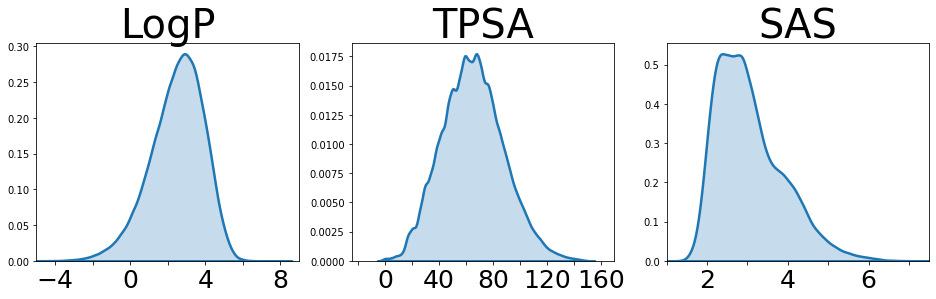

In [14]:
plt.figure(figsize=(16,4))


###
plt.subplot(1, 3, 1)
sns.kdeplot(data_df.logP.values, linewidth=2.5, fill=True)
plt.title("LogP", fontsize=40)
plt.ylabel('')
plt.xticks(fontsize=25)
plt.xlim(-5, 9)

ax = plt.gca()
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)


###
plt.subplot(1, 3, 2)
sns.kdeplot(data_df.tpsa.values, linewidth=2.5, fill=True)
plt.title("TPSA", fontsize=40)
plt.ylabel('')
plt.xticks(np.arange(-20, 161, 20), fontsize=25)
plt.xlim(-25, 170)

ax = plt.gca()
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)


# # ###
plt.subplot(1, 3, 3)
sns.kdeplot(data_df.SAS.values, linewidth=2.5, fill=True)
plt.title("SAS", fontsize=40)
plt.ylabel('')
plt.xticks(fontsize=25)
plt.xlim(1, 7.5)

ax = plt.gca()
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

plt.show()

# Features generation

In this setting, we iterate through the dataset and change the LogP of every molecule to the specified value. The values of other properties remain the same. However one could also establish their value to constant or for example to dataset mean.

### 1.5

100%|██████████| 50/50 [00:18<00:00,  2.69it/s]


generated    1.972084
dtype: float64


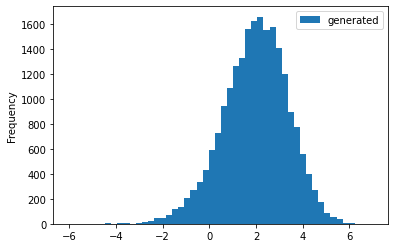

In [14]:
batch_size = 512

all_generated_logP = []

for batch_num in tqdm(range(50)):
    make_labels = torch.randn((batch_size,z_size)).to(device)
    
    make_labels[:,0] = 1.5
    make_labels[:,1] = torch.randn((batch_size)).to(device) * tpsa_std + tpsa_mean
    make_labels[:,2] = torch.randn((batch_size)).to(device) * sas_std + sas_mean
    
    new_z = model.flow.inv_flow(make_labels)
    generated = vae.decoder.generate(new_z, n_steps=60, temperature=1.)

    smi_list = return_smiles(generated, SRC)
    mol_list = [Chem.MolFromSmiles(smi) for smi in smi_list]
    mol_list = [mol for mol in mol_list if mol is not None]

    all_generated_logP.append([Chem.Crippen.MolLogP(mol) for mol in mol_list])
    
generated_logP_15 = [x for logP_list in all_generated_logP for x in logP_list]

scores_df = pd.DataFrame(
    {'generated': generated_logP_15})

print(scores_df.mean())

# scores_df.generated.plot.density()
scores_df.generated.plot.hist(bins=50)
plt.legend()
plt.show()

### 3.0

100%|██████████| 50/50 [00:18<00:00,  2.70it/s]


generated    3.414952
dtype: float64


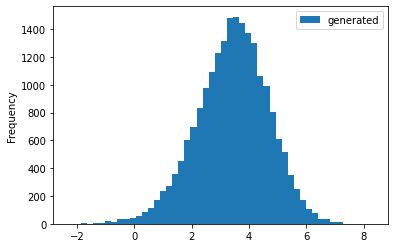

In [15]:
batch_size = 512

all_generated_logP = []

for batch_num in tqdm(range(50)):
    make_labels = torch.randn((batch_size,z_size)).to(device)
    
    make_labels[:,0] = 3.0
    make_labels[:,1] = torch.randn((batch_size)).to(device) * tpsa_std + tpsa_mean
    make_labels[:,2] = torch.randn((batch_size)).to(device) * sas_std + sas_mean
    
    new_z = model.flow.inv_flow(make_labels)
    generated = vae.decoder.generate(new_z, n_steps=60, temperature=1.)

    smi_list = return_smiles(generated, SRC)
    mol_list = [Chem.MolFromSmiles(smi) for smi in smi_list]
    mol_list = [mol for mol in mol_list if mol is not None]

    all_generated_logP.append([Chem.Crippen.MolLogP(mol) for mol in mol_list])
    
generated_logP_30 = [x for logP_list in all_generated_logP for x in logP_list]

scores_df = pd.DataFrame(
    {'generated': generated_logP_30})

print(scores_df.mean())

# scores_df.generated.plot.density()
scores_df.generated.plot.hist(bins=50)
plt.legend()
plt.show()

### 4.5

100%|██████████| 50/50 [00:15<00:00,  3.17it/s]


generated    4.350046
dtype: float64


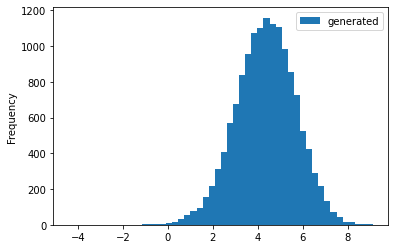

In [16]:
batch_size = 512

all_generated_logP = []

for batch_num in tqdm(range(50)):
    make_labels = torch.randn((batch_size,z_size)).to(device)
    
    make_labels[:,0] = 4.5
    make_labels[:,1] = torch.randn((batch_size)).to(device) * tpsa_std + tpsa_mean
    make_labels[:,2] = torch.randn((batch_size)).to(device) * sas_std + sas_mean
    
    new_z = model.flow.inv_flow(make_labels)
    generated = vae.decoder.generate(new_z, n_steps=60, temperature=1.)

    smi_list = return_smiles(generated, SRC)
    mol_list = [Chem.MolFromSmiles(smi) for smi in smi_list]
    mol_list = [mol for mol in mol_list if mol is not None]

    all_generated_logP.append([Chem.Crippen.MolLogP(mol) for mol in mol_list])
    
generated_logP_45 = [x for logP_list in all_generated_logP for x in logP_list]

scores_df = pd.DataFrame(
    {'generated': generated_logP_45})

print(scores_df.mean())

# scores_df.generated.plot.density()
scores_df.generated.plot.hist(bins=50)
plt.legend()
plt.show()

### All together

In [19]:
len(data_df.logP.values), len(generated_logP_15), len(generated_logP_30), len(generated_logP_45)

(249455, 23859, 21701, 11070)

In [20]:
sample_size = 11000

scores_df = pd.DataFrame(
    {'original': data_df.logP.values[:sample_size],
     'generated 1.5': generated_logP_15[:sample_size],
     'generated 3.0': generated_logP_30[:sample_size],
     'generated 4.5': generated_logP_45[:sample_size]})

original_df = pd.DataFrame({'original': data_df.logP.values})
df_15 = pd.DataFrame({'generated 1.5': generated_logP_15})
df_3 = pd.DataFrame({'generated 1.5': generated_logP_30})
df_45 = pd.DataFrame({'generated 4.5': generated_logP_45})

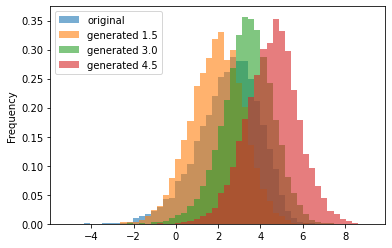

In [23]:
scores_df.plot.hist(bins=50, alpha=0.6, density=True)
plt.legend()
plt.show()